# Qiskit - Custom Unitary


Thomas Alexander

### Normal imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

import qiskit
from qiskit import IBMQ, execute
import qiskit.pulse as pulse
from qiskit.pulse import pulse_lib, schedule

## Load backends per-usual

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [3]:
config = backend.configuration()

In [4]:
defaults = backend.defaults()

In [5]:
inst_map = defaults.instruction_schedule_map

## Calibrate our x90/180 pulses first
Lets run through a Rabi experiment with pulse, from program building to data analysis

First we need to define some relevant parameters

In [6]:
qubit = 0
shots = 256

In [7]:
drive_samples = 1024
drive_sigma = drive_samples / 4

In [8]:
meas_samples = 16000
meas_amp = 0.6
meas_sigma = 48
meas_risefall = 448

### Circuit instructions are composite in pulse

### Define our measurement schedule

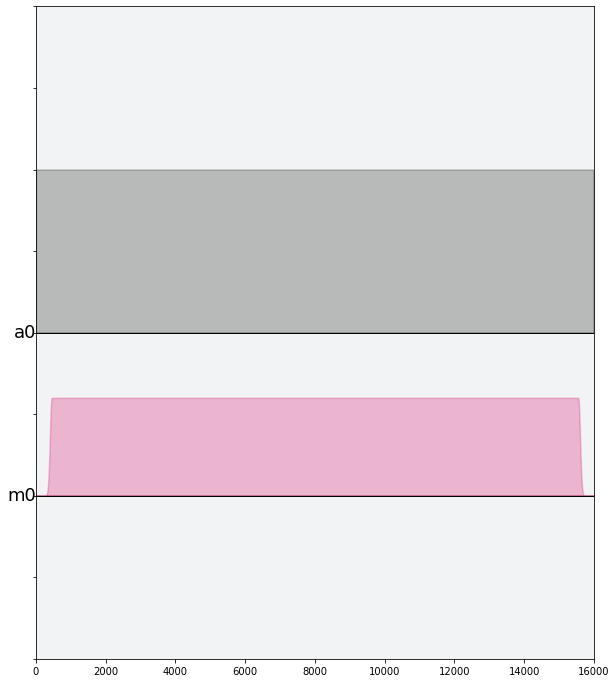

In [9]:
# First we need to define our measurement operation that we can reuse
measure = pulse.Schedule()
measure_pulse = pulse_lib.gaussian_square(meas_samples, meas_amp, meas_sigma, meas_risefall)
acquire = pulse.Acquire(meas_samples)

measure += measure_pulse(pulse.MeasureChannel(0))
measure += acquire(pulse.AcquireChannel(0), pulse.MemorySlot(0))
measure.draw()

# Let's build our experiment!

define some parameters for the Rabi experiment

In [10]:
# Rabi experiment parameters
n_rabi_points = 50

# Drive amplitude values to iterate over: 64 amplitudes evenly spaced from 0 to 0.1
drive_amp_min = 0
drive_amp_max = 0.70
rabi_amps = np.linspace(drive_amp_min, drive_amp_max, n_rabi_points)

we construct our Rabi pulse program

In [13]:
rabi_schedules = []

drive_channel = pulse.DriveChannel(qubit)

for drive_amp in rabi_amps:
    sched = pulse.Schedule()
    rabi_pulse = pulse_lib.gaussian(drive_samples, drive_amp, drive_sigma)
    sched += rabi_pulse(drive_channel)
    sched += measure << sched.duration
    rabi_schedules.append(sched)

Plot our Rabi schedule

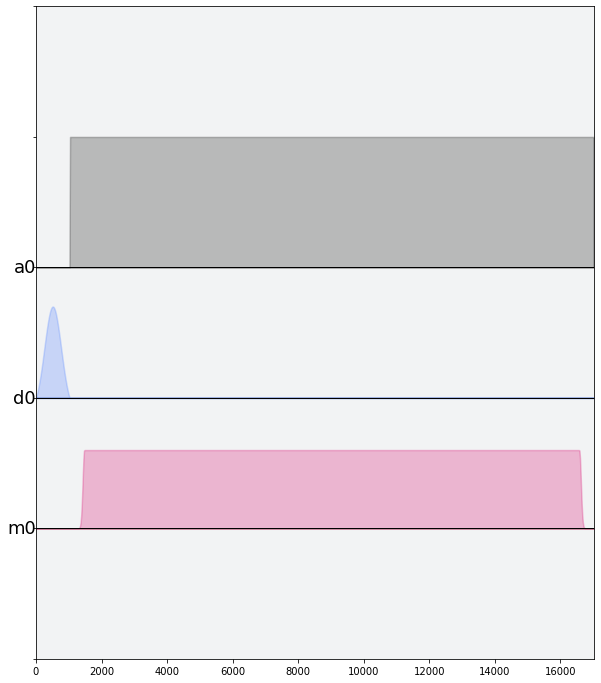

In [14]:
rabi_schedules[-1].draw()

## Execute our Experiment

In [15]:
rabi_job = qiskit.execute(rabi_schedules, backend, meas_level=1, meas_return='avg', shots=shots)
print(rabi_job.job_id())
rabi_result = rabi_job.result()

5e548517e0084d0018790c3a


### get our results

In [16]:
rabi_data = np.asarray([rabi_result.get_memory(i) for i in range(n_rabi_points)]).reshape(-1)

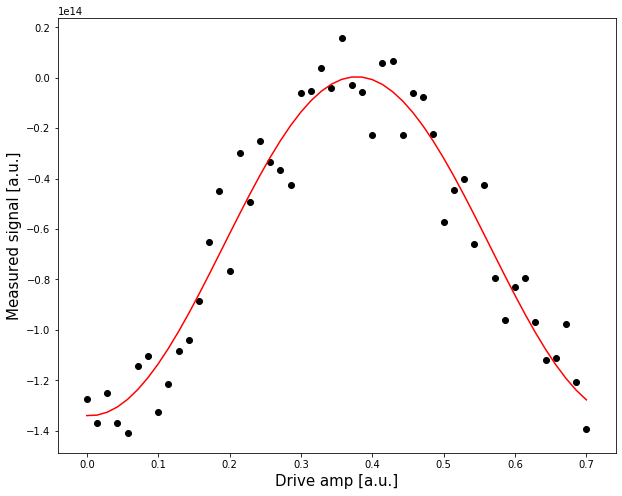

In [30]:
def sinusoid(x, A, B, drive_period, phi):
    return (A*np.cos(2*np.pi*x/drive_period - phi) + B)

fit_params, y_fit = curve_fit(sinusoid,
                              rabi_amps,
                              rabi_data,
                              [1.0e14, -0.5e14, -0.5, 0])
plt.figure(figsize=(10, 8))
plt.scatter(rabi_amps, rabi_data, color='black')
plt.plot(rabi_amps, sinusoid(rabi_amps, *fit_params), color='red')
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [31]:
_,_,drive_period,_ = fit_params
pi_amp = abs(drive_period / 2)
pi2_amp = pi_amp /2 
print(f"π Amplitude = {pi_amp}")
print(f"π/2 Amplitude = {pi2_amp}")

π Amplitude = 0.37368506750784397
π/2 Amplitude = 0.18684253375392199


### Our $\pi$ and $\pi/2$ pulses!
Let's define our pulse, with the amplitude we just found, so we can use it in later experiments.

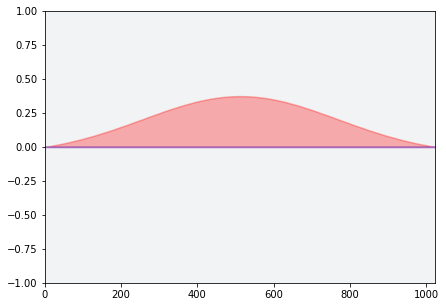

In [32]:
x180_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=bdrive_sigma,
                              name='x180')
x180_pulse.draw()

In [36]:
x90p_pulse = pulse_lib.gaussian(duration=drive_samples,
                                amp=pi2_amp, 
                                sigma=drive_sigma,
                                name='x90p')
x90m_pulse = pulse_lib.gaussian(duration=drive_samples,
                                amp=-pi2_amp, 
                                sigma=drive_sigma,
                                name='x90m')

## What if we want to use our own calibrated x90p/m gates?
lets start with a new instruction map

In [37]:
our_inst_map = copy.deepcopy(inst_map)

### and create a parameterized schedule

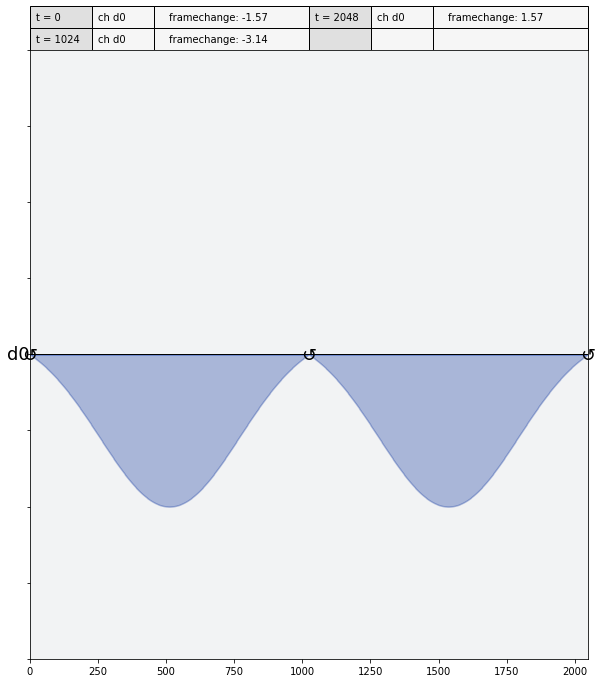

In [38]:
from qiskit.pulse.schedule import ParameterizedSchedule

def u3_q0_fun(P1, P2, P3):
    schedule = pulse.Schedule()
    schedule += pulse.FrameChange(-P3)(drive_channel)
    schedule += x90p_pulse(drive_channel)
    schedule += pulse.FrameChange(-P1)(drive_channel)
    schedule += x90m_pulse(drive_channel)
    schedule += pulse.FrameChange(-P2)(drive_channel)
    return schedule

u3_q0 = ParameterizedSchedule(u3_q0_fun, parameters=('P1', 'P2', 'P3'))
u3_q0(np.pi, -np.pi/2, np.pi/2).draw()

### add it to our map replacing the old pulse definition

In [41]:
our_inst_map.add('u3', (0,), u3_q0)
print(u3_q0(np.pi, -np.pi/2, np.pi/2) == our_inst_map.get('u3', (0,), np.pi, -np.pi/2, np.pi/2))

True


## Scheduling a circuit into a pulse schedule
first build our circuit

In [43]:
qc = qiskit.QuantumCircuit(1, 1)
qc.rx(np.pi, 0)
qc.measure(0, 0)
qc.draw()

┌────────┐┌─┐
q_0: |0>┤ Rx(pi) ├┤M├
        └────────┘└╥┘
 c_0: 0 ═══════════╩═

### Transpile for our device

In [44]:
qc_transpiled = qiskit.transpile(qc, backend)
qc_transpiled.draw()

┌───────────────────┐┌─┐
q_0: |0>┤ U3(pi,-pi/2,pi/2) ├┤M├
        └───────────────────┘└╥┘
 c_0: 0 ══════════════════════╩═

### We can now schedule our circuit with our new pulse

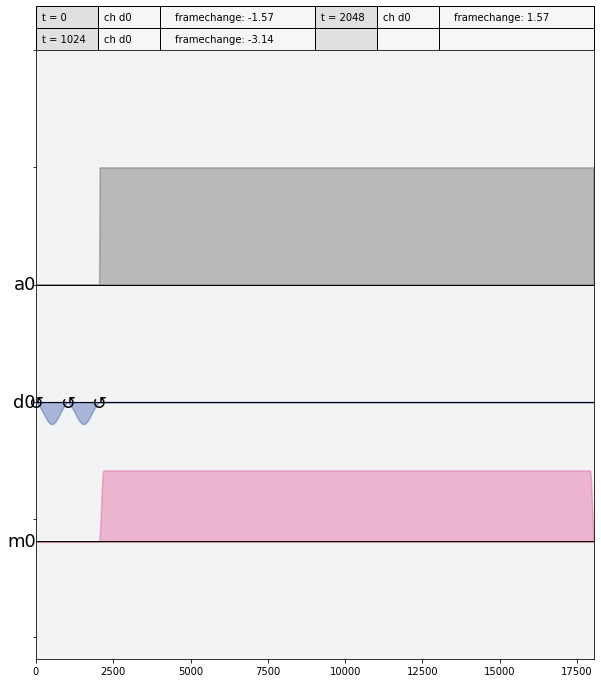

In [45]:
our_scheduled_qc = qiskit.schedule(qc_transpiled, backend, inst_map=our_inst_map, method='alap')
our_scheduled_qc.draw()

### Run our circuit with our scheduled pulse

In [46]:
our_scheduled_qc_job = qiskit.execute(our_scheduled_qc, backend, shots=shots)
print(our_scheduled_qc_job.job_id())
our_scheduled_qc_result = our_scheduled_qc_job.result()

5e5489a2c3e1b80018b1affb


In [47]:
our_scheduled_qc_counts = our_scheduled_qc_result.get_counts(0)
print(our_scheduled_qc_counts)

{'0': 14, '1': 242}


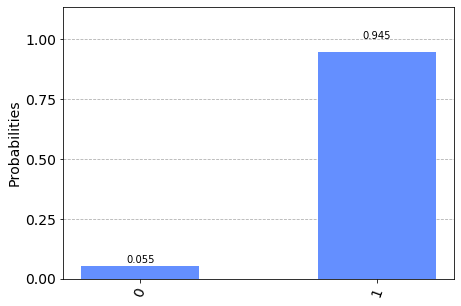

In [50]:
qiskit.visualization.plot_histogram([our_scheduled_qc_counts])

## What about designing a new gate in qiskit?

First we build our perfect gate as a schecule

In [79]:
my_perfect_2q_gate_schedule = pulse.Schedule(name='my_perfect_2q_gate')

random_pulse = lambda x: pulse.SamplePulse(np.random.random(max(x, 1)))

def my_perfect_2q_gate_schedule_fun(x):
    sched = pulse.Schedule()
    sched += random_pulse(x)(pulse.DriveChannel(0))
    sched += random_pulse(x)(pulse.ControlChannel(0))
    sched += random_pulse(x)(pulse.DriveChannel(1))
    return sched

my_perfect_2q_gate_schedule = ParameterizedSchedule(my_perfect_2q_gate_schedule_fun, parameters=('x'))

### Add the schedule to our circuit instruction mapping

In [80]:
our_inst_map.add('my_perfect_2q_gate', (0, 1), my_perfect_2q_gate_schedule)

and create a circuit gate that we can add to a circuit setting our gate length to 100

In [81]:
my_perfect_2q_gate = qiskit.circuit.Gate('my_perfect_2q_gate', 2, [100])

### We then build our circuit as normal

In [82]:
my_perfect_2q_circ = qiskit.QuantumCircuit(2, 2)
my_perfect_2q_circ.h(0)
my_perfect_2q_circ.append(my_perfect_2q_gate, [0, 1])
my_perfect_2q_circ.h(0)
my_perfect_2q_circ.measure(0, 0)

Don't forget to add it to our basis gates!

In [83]:
my_perfect_2q_circ_transpiled = qiskit.transpile(my_perfect_2q_circ, coupling_map=[[0, 1]], 
                                                 basis_gates=config.basis_gates+['my_perfect_2q_gate'])
my_perfect_2q_circ_transpiled.draw()

┌──────────┐┌──────────────────────────┐┌──────────┐┌─┐
q_0 -> 0 |0>┤ U2(0,pi) ├┤0                         ├┤ U2(0,pi) ├┤M├
            └──────────┘│  My_perfect_2q_gate(100) │└──────────┘└╥┘
q_1 -> 1 |0>────────────┤1                         ├─────────────╫─
                        └──────────────────────────┘             ║ 
     c_0: 0 ═════════════════════════════════════════════════════╩═
                                                                   
     c_1: 0 ═══════════════════════════════════════════════════════

### We can then schedule our circuit by passing it our modified map

In [84]:
my_perfect_2q_pulse_program = qiskit.schedule(my_perfect_2q_circ_transpiled, 
                                              inst_map=our_inst_map, 
                                              meas_map=[[0]])

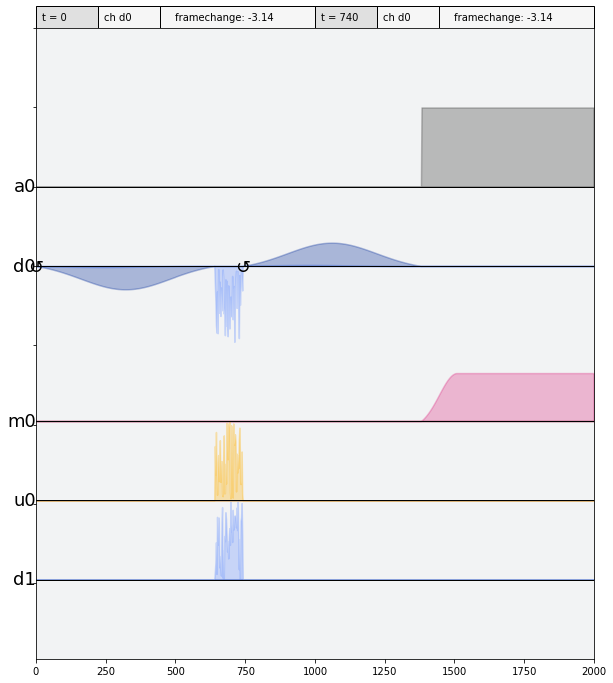

In [85]:
my_perfect_2q_pulse_program.draw(plot_range=(0, 2000))